Based on the details from the paper, we can enhance the physical battery model by incorporating:

- Real battery parameters such as capacity (42.5 Ah), nominal voltage (3.65V), and rated voltage range (2.5V - 4.2V).
- Thermal behavior using a more realistic thermal model, considering thermal conductivity, specific heat, and Joule heating.
- Charge/discharge cycles matching the constant-current (CC) and constant-voltage (CV) protocols used in the experiments.
- Environmental chamber constraints (ambient temperature = 25°C).

In [1]:
# === 1. Imports === #
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# === 2. Load and Normalize Real Sensor + Thermal Image Data === #
# Load from paired CSV
paired_csv_path = "paired/1_and_3C_anomaly_paired.csv"
df = pd.read_csv(paired_csv_path)
sensor_columns = ["Current_A_", "Voltage_V_", "Energy_Wh_"]
sensor_data = torch.tensor(df[sensor_columns].values, dtype=torch.float32)
sensor_data = (sensor_data - sensor_data.mean(dim=0)) / sensor_data.std(dim=0)
image_paths = df["Matched_Image"].values

def load_and_preprocess_image(image_path, size=(480, 640)):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path).convert("L")
    return transform(image)

image_data = torch.stack([load_and_preprocess_image(path) for path in image_paths])

In [2]:
# === 3. Define Physics-Based Sensor Generator & Model === #
def generate_physics_based_sensor_data(batch_size=32):
    current = np.random.uniform(0, 5, batch_size)
    voltage = np.random.uniform(3.0, 4.2, batch_size)
    energy = current * voltage * 0.1
    # soc = 100 - np.cumsum(current) % 100
    # temperature = 25 + (current ** 2) * 0.5
    sensor_data = np.stack([current, voltage, energy], axis=1)
    return torch.tensor(sensor_data, dtype=torch.float32)

def physical_battery_model(current, voltage, capacity=42.5, resistance=0.005, ambient_temp=25):
    power = current * voltage
    energy = torch.cumsum(power, dim=0) / 3600
    soc = 100 - (torch.cumsum(current, dim=0) / capacity * 100)
    soc = torch.clamp(soc, 0, 100)
    heat = resistance * current ** 2
    temp = ambient_temp + torch.cumsum(heat, dim=0) * 0.1
    return energy

def physics_loss(fake_sensor_data):
    with torch.no_grad():
        current = fake_sensor_data[:, 0]
        voltage = fake_sensor_data[:, 1]
        expected_energy= physical_battery_model(current, voltage)
        loss = (
            torch.mean((fake_sensor_data[:, 2] - expected_energy) ** 2) 
            # torch.mean((fake_sensor_data[:, 3] - expected_soc) ** 2) +
            # torch.mean((fake_sensor_data[:, 4] - expected_temp) ** 2)
        )
    return loss

# === 4. Define cGAN Models === #
class Generator(nn.Module):
    def __init__(self, sensor_dim, noise_dim, output_shape=(1, 480, 640)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(sensor_dim + noise_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, int(np.prod(output_shape))),
            nn.Tanh()
        )
        self.output_shape = output_shape

    def forward(self, sensor_input, noise):
        x = torch.cat((sensor_input, noise), dim=1)
        out = self.model(x)
        return out.view(-1, *self.output_shape)

class Discriminator(nn.Module):
    def __init__(self, sensor_dim, image_shape=(1, 480, 640)):
        super().__init__()
        input_dim = sensor_dim + int(np.prod(image_shape))
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            # nn.Sigmoid()
        )

    def forward(self, sensor_input, image_input):
        x = torch.cat((sensor_input, image_input.view(image_input.size(0), -1)), dim=1)
        return self.model(x)

def compute_gradient_penalty(D, real_samples, fake_samples, sensor_input):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    d_interpolates = D(sensor_input, interpolates)
    fake = torch.ones(d_interpolates.size()).to(real_samples.device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [4]:
# === 5. Training Configuration === #
sensor_dim = 3
noise_dim = 10
image_shape = (1, 480, 640)
batch_size = 64
epochs = 20000

G = Generator(sensor_dim, noise_dim, image_shape)
D = Discriminator(sensor_dim, image_shape)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.00005, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=0.00005, betas=(0.0, 0.9))

lambda_gp = 10

# Train Critic more often
n_critic = 10  # update critic 5 times per generator step
lambda_physics = 10
for epoch in range(epochs):
    for _ in range(n_critic):
        
        indices = np.random.randint(0, len(sensor_data), batch_size)
        real_sensor = sensor_data[indices]
        real_images = image_data[indices]
        noise = torch.randn(batch_size, noise_dim) 
        fake_images = G(real_sensor, noise)

        real_pred = D(real_sensor, real_images)
        fake_pred = D(real_sensor, fake_images.detach())

        gp = compute_gradient_penalty(D, real_images, fake_images.detach(), real_sensor)

        d_loss = -torch.mean(real_pred) + torch.mean(fake_pred) + lambda_gp * gp
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()
        
 
    # === Train Generator ===
    noise = torch.randn(batch_size, noise_dim) 
    fake_images = G(real_sensor, noise)
    fake_pred = D(real_sensor, fake_images)
    g_loss = -torch.mean(fake_pred)

    # Optional: Add physics loss
    phys_loss = physics_loss(real_sensor)
    total_g_loss = g_loss + lambda_physics * phys_loss

    optimizer_G.zero_grad()
    total_g_loss.backward()
    optimizer_G.step()

    # === Log ===
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | Physics Loss: {phys_loss:.4f} | Total G Loss: {total_g_loss.item():.4f}")


Epoch 0/20000 | D Loss: -208.1153 | G Loss: 11.8076 | Physics Loss: 1.5557 | Total G Loss: 27.3645
Epoch 100/20000 | D Loss: -11.8428 | G Loss: -355.4535 | Physics Loss: 0.9027 | Total G Loss: -346.4268
Epoch 200/20000 | D Loss: -48.6679 | G Loss: 52.9603 | Physics Loss: 1.2658 | Total G Loss: 65.6186
Epoch 300/20000 | D Loss: -34.1300 | G Loss: -237.9841 | Physics Loss: 1.0514 | Total G Loss: -227.4704
Epoch 400/20000 | D Loss: 1.8750 | G Loss: 232.0811 | Physics Loss: 1.1086 | Total G Loss: 243.1673
Epoch 500/20000 | D Loss: -30.5407 | G Loss: -227.8654 | Physics Loss: 0.6946 | Total G Loss: -220.9190
Epoch 600/20000 | D Loss: 22.0463 | G Loss: 186.1770 | Physics Loss: 0.8576 | Total G Loss: 194.7535
Epoch 700/20000 | D Loss: -11.7321 | G Loss: -147.0935 | Physics Loss: 0.8312 | Total G Loss: -138.7810
Epoch 800/20000 | D Loss: -23.5728 | G Loss: -199.4180 | Physics Loss: 0.7950 | Total G Loss: -191.4681
Epoch 900/20000 | D Loss: 33.7998 | G Loss: 89.8970 | Physics Loss: 0.9881 | Tot

KeyboardInterrupt: 

In [5]:
# Save model
torch.save(G.state_dict(), "generator_Wgan_20k.pth")
torch.save(D.state_dict(), "discriminator_Wgan_20k.pth")

In [7]:
torch.save({
    'epoch': epoch,  # replace with the actual current epoch number
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
}, 'checkpoint_last.pth')


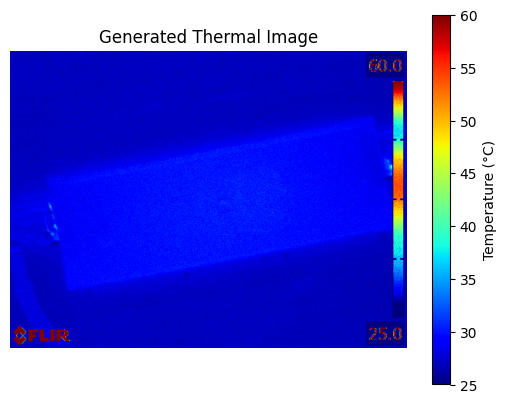

SSIM: 0.3145, PSNR: 8.42 dB
tensor([[4.9919, 3.4344, 1.7144]])


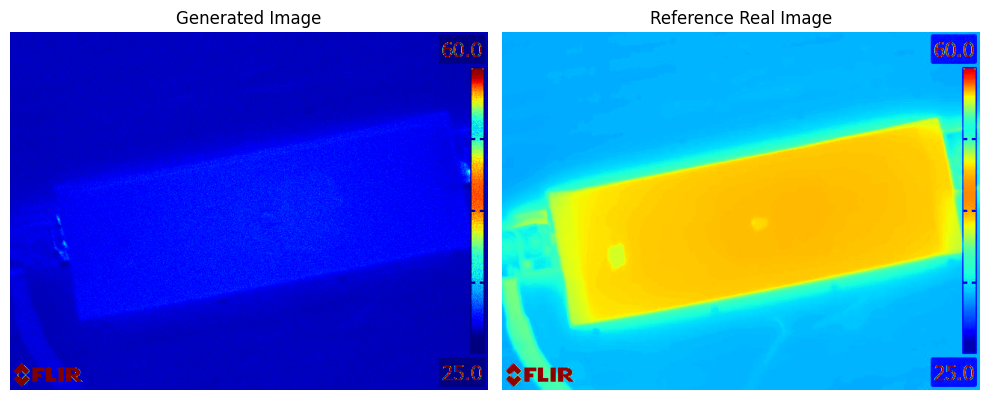

In [9]:
# === 7. Generate, Save, Evaluate, and Visualize === #
def show_generated_image(image_tensor):
    img = image_tensor.squeeze().detach().cpu().numpy()
    img_rescaled = (img + 1) / 2 * (60 - 25) + 25
    plt.imshow(img_rescaled, cmap="jet", vmin=25, vmax=60)
    cbar = plt.colorbar()
    cbar.set_label("Temperature (°C)")
    plt.axis("off")
    plt.title("Generated Thermal Image")
    plt.show()
    return img_rescaled

def save_image_and_sensor(img_array, sensor_tensor, output_dir="outputs", index=0):
    os.makedirs(output_dir, exist_ok=True)
    plt.imsave(os.path.join(output_dir, f"generated_image_{index:04d}.png"), img_array, cmap="jet", vmin=25, vmax=60)
    np.savetxt(os.path.join(output_dir, f"sensor_data_{index:04d}.csv"), sensor_tensor.cpu().numpy(), delimiter=",")

def evaluate_image_quality(generated, reference):
    generated = (generated + 1) / 2  # Normalize to [0,1]
    reference = (reference + 1) / 2
    generated_np = generated.squeeze().detach().cpu().numpy()
    reference_np = reference.squeeze().detach().cpu().numpy()
    return ssim(generated_np, reference_np, data_range=1.0), psnr(generated_np, reference_np, data_range=1.0)

# Generate synthetic sensor from physics-based model and use generator
synth_sensor = generate_physics_based_sensor_data(1)
synth_sensor = (synth_sensor - sensor_data.mean(dim=0)) / sensor_data.std(dim=0)
noise_sample = torch.randn(1, noise_dim)
fake_image = G(synth_sensor, noise_sample)

# Visualization
img_rescaled = show_generated_image(fake_image)

# Save to disk
save_image_and_sensor(img_rescaled, synth_sensor, index=0)

# Evaluate quality (if reference is available)
reference_image = real_images[0]
ssim_val, psnr_val = evaluate_image_quality(fake_image, reference_image)
print(f"SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f} dB")

print(synth_sensor)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img_rescaled, cmap="jet",  vmin=25, vmax=60)
axs[0].set_title("Generated Image")
axs[0].axis('off')

real_ref_rescaled = (reference_image.squeeze().detach().cpu().numpy() + 1) / 2 * (60 - 25) + 25
axs[1].imshow(real_ref_rescaled,  cmap="jet", vmin=25, vmax=60)
axs[1].set_title("Reference Real Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()


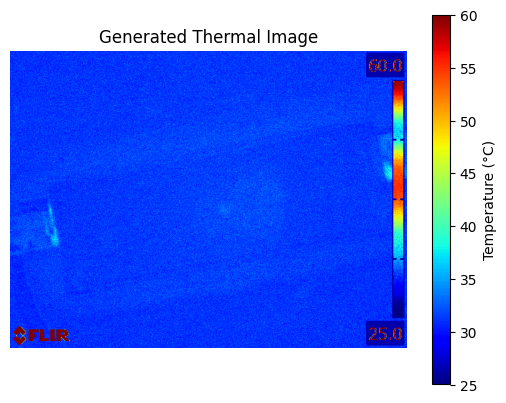

SSIM: 0.5983, PSNR: 22.95 dB
tensor([[2.9367, 4.1538, 1.2198]])


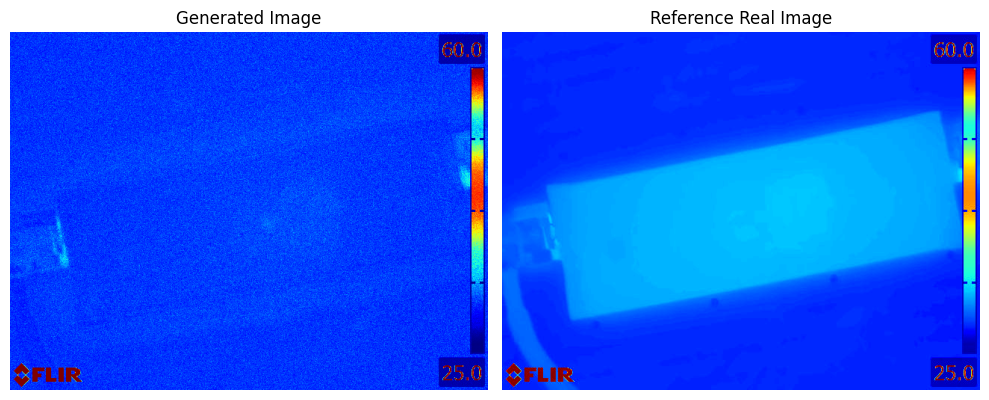

In [5]:
# === 7. Generate, Save, Evaluate, and Visualize === #
def show_generated_image(image_tensor):
    img = image_tensor.squeeze().detach().cpu().numpy()
    img_rescaled = (img + 1) / 2 * (60 - 25) + 25
    plt.imshow(img_rescaled, cmap="jet", vmin=25, vmax=60)
    cbar = plt.colorbar()
    cbar.set_label("Temperature (°C)")
    plt.axis("off")
    plt.title("Generated Thermal Image")
    plt.show()
    return img_rescaled

def save_image_and_sensor(img_array, sensor_tensor, output_dir="outputs", index=0):
    os.makedirs(output_dir, exist_ok=True)
    plt.imsave(os.path.join(output_dir, f"generated_image_{index:04d}.png"), img_array, cmap="jet", vmin=25, vmax=60)
    np.savetxt(os.path.join(output_dir, f"sensor_data_{index:04d}.csv"), sensor_tensor.cpu().numpy(), delimiter=",")

def evaluate_image_quality(generated, reference):
    generated = (generated + 1) / 2  # Normalize to [0,1]
    reference = (reference + 1) / 2
    generated_np = generated.squeeze().detach().cpu().numpy()
    reference_np = reference.squeeze().detach().cpu().numpy()
    return ssim(generated_np, reference_np, data_range=1.0), psnr(generated_np, reference_np, data_range=1.0)

# Generate synthetic sensor from physics-based model and use generator
synth_sensor = generate_physics_based_sensor_data(1)
synth_sensor = (synth_sensor - sensor_data.mean(dim=0)) / sensor_data.std(dim=0)
noise_sample = torch.randn(1, noise_dim)
fake_image = G(synth_sensor, noise_sample)

# Visualization
img_rescaled = show_generated_image(fake_image)

# Save to disk
save_image_and_sensor(img_rescaled, synth_sensor, index=0)

# Evaluate quality (if reference is available)
reference_image = real_images[0]
ssim_val, psnr_val = evaluate_image_quality(fake_image, reference_image)
print(f"SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f} dB")

print(synth_sensor)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img_rescaled, cmap="jet",  vmin=25, vmax=60)
axs[0].set_title("Generated Image")
axs[0].axis('off')

real_ref_rescaled = (reference_image.squeeze().detach().cpu().numpy() + 1) / 2 * (60 - 25) + 25
axs[1].imshow(real_ref_rescaled,  cmap="jet", vmin=25, vmax=60)
axs[1].set_title("Reference Real Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [10]:
# === 6. Generate 100 Images and Save === #
output_dir = "sythetic_data_wgan_GP"
os.makedirs(output_dir, exist_ok=True)
all_sensors = []

for i in range(1000):
    sensor = generate_physics_based_sensor_data(1)
    norm_sensor = (sensor - sensor_data.mean(dim=0)) / sensor_data.std(dim=0)
    noise = torch.randn(1, noise_dim)
    fake_img = G(norm_sensor, noise)

    img_np = fake_img.squeeze().detach().cpu().numpy()
    img_rescaled = (img_np + 1) / 2 * (60 - 25) + 25
    img_path = os.path.join(output_dir, f"gen_image_{i:03d}.png")
    sensor_path = os.path.join(output_dir, f"sensor_data.csv")

    plt.imsave(img_path, img_rescaled, cmap="jet", vmin=25, vmax=60)
    all_sensors.append(sensor.numpy().squeeze())

pd.DataFrame(all_sensors, columns=sensor_columns).to_csv(sensor_path, index=False)
print(f"Saved 100 images and sensor data to '{output_dir}'")

Saved 100 images and sensor data to 'sythetic_data_wgan_GP'


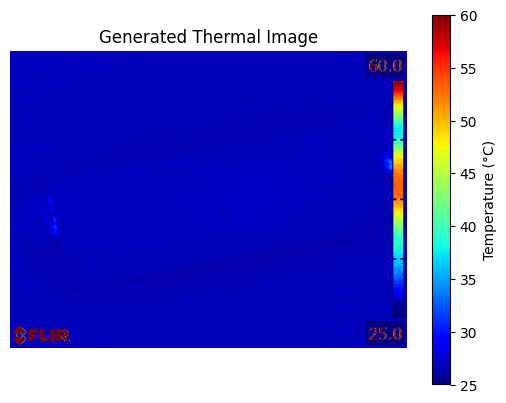

SSIM: 0.4984, PSNR: 18.84 dB


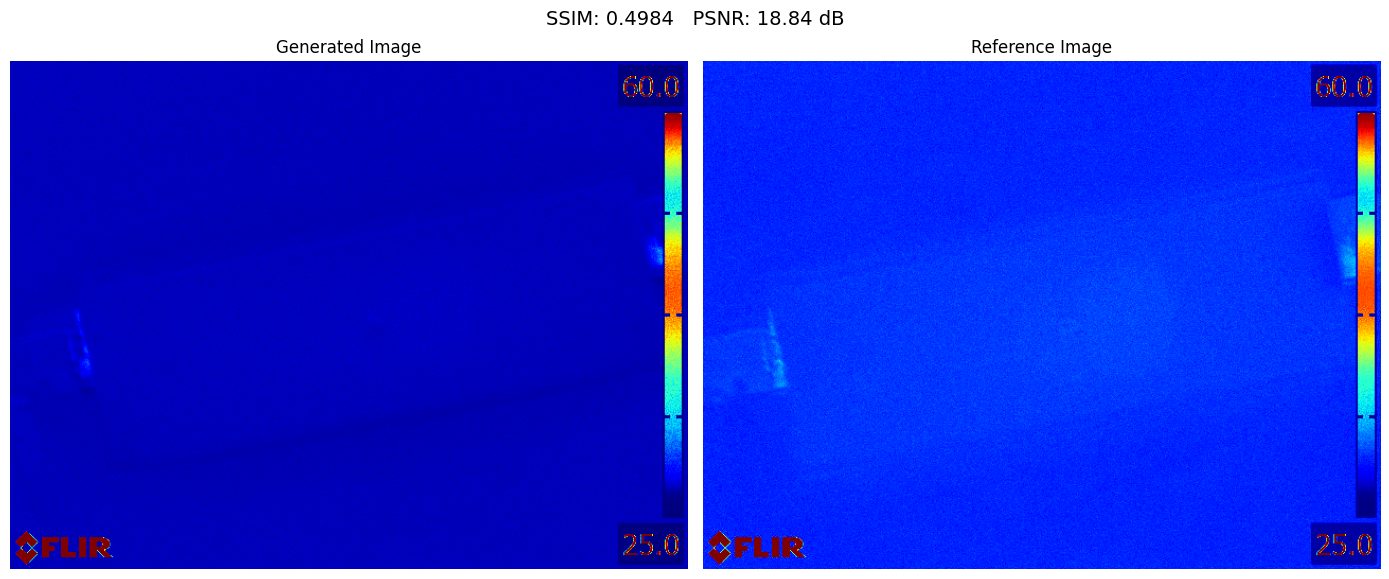

In [12]:
# import os
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from torchvision import transforms

# # === Generator definition ===
# # === 4. Define cGAN Models === #
# class Generator(torch.nn.Module):
#     def __init__(self, sensor_dim, noise_dim, output_shape=(1, 480, 640)):
#         super().__init__()
#         self.model = torch.nn.Sequential(
#             torch.nn.Linear(sensor_dim + noise_dim, 512),
#             torch.nn.ReLU(),
#             torch.nn.Linear(512, 1024),
#             torch.nn.ReLU(),
#             torch.nn.Linear(1024, int(np.prod(output_shape))),
#             torch.nn.Tanh()
#         )
#         self.output_shape = output_shape

#     def forward(self, sensor_input, noise):
#         x = torch.cat((sensor_input, noise), dim=1)
#         out = self.model(x)
#         return out.view(-1, *self.output_shape)


# # === Physics-based sensor generation ===
# def generate_physics_based_sensor_data(batch_size=1):
#     current = np.random.uniform(0, 5, batch_size)
#     voltage = np.random.uniform(3.0, 4.2, batch_size)
#     energy = current * voltage * 0.1
#     sensor_data = np.stack([current, voltage, energy], axis=1)
#     return torch.tensor(sensor_data, dtype=torch.float32)

# # === Image rescaling & visualization ===
# def show_generated_image(image_tensor):
#     img = image_tensor.squeeze().detach().cpu().numpy()
#     img_rescaled = (img + 1) / 2 * (60 - 25) + 25
#     plt.imshow(img_rescaled, cmap="jet", vmin=25, vmax=60)
#     cbar = plt.colorbar()
#     cbar.set_label("Temperature (°C)")
#     plt.axis("off")
#     plt.title("Generated Thermal Image")
#     plt.show()
#     return img_rescaled

# def save_image_and_sensor(img_array, sensor_tensor, output_dir="outputs", index=0):
#     os.makedirs(output_dir, exist_ok=True)
#     plt.imsave(os.path.join(output_dir, f"generated_image_{index:04d}.png"), img_array, cmap="jet", vmin=25, vmax=60)
#     np.savetxt(os.path.join(output_dir, f"generated_sensors.csv"), sensor_tensor.cpu().numpy(), delimiter=",")

# def evaluate_image_quality(generated, reference):
#     generated = (generated + 1) / 2
#     reference = (reference + 1) / 2
#     g_np = generated.squeeze().detach().cpu().numpy()
#     r_np = reference.squeeze().detach().cpu().numpy()
#     return ssim(r_np, g_np, data_range=1.0), psnr(r_np, g_np, data_range=1.0)

# # === Settings ===
# sensor_dim = 3
# noise_dim = 10
# image_shape = (1, 480, 640)
# model_path = "generator_Wgan_20k.pth"

# # === Load Generator ===
# G = Generator(sensor_dim, noise_dim, image_shape)
# G.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# G.eval()

# === Prepare input ===
synth_sensor = generate_physics_based_sensor_data(1)
noise_sample = torch.randn(1, noise_dim)
fake_image = G(synth_sensor, noise_sample)

# === Visualization and Save ===
img_rescaled = show_generated_image(fake_image)
save_image_and_sensor(img_rescaled, synth_sensor, index=0)

# === Evaluate (if reference image exists) ===
# For demonstration: fake reference from same generator
reference_image = G(synth_sensor, torch.randn(1, noise_dim))  # ideally from real dataset
ssim_val, psnr_val = evaluate_image_quality(fake_image, reference_image)
print(f"SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f} dB")

# === Rescale both fake and reference ===
fake_rescaled = (fake_image.squeeze().detach().cpu().numpy() + 1) / 2 * (60 - 25) + 25
ref_rescaled = (reference_image.squeeze().detach().cpu().numpy() + 1) / 2 * (60 - 25) + 25

# === Plot side-by-side ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].imshow(fake_rescaled, cmap="jet", vmin=25, vmax=60)
axs[0].set_title("Generated Image")
axs[0].axis("off")

axs[1].imshow(ref_rescaled, cmap="jet", vmin=25, vmax=60)
axs[1].set_title("Reference Image")
axs[1].axis("off")

plt.suptitle(f"SSIM: {ssim_val:.4f}   PSNR: {psnr_val:.2f} dB", fontsize=14)
plt.tight_layout()
plt.show()


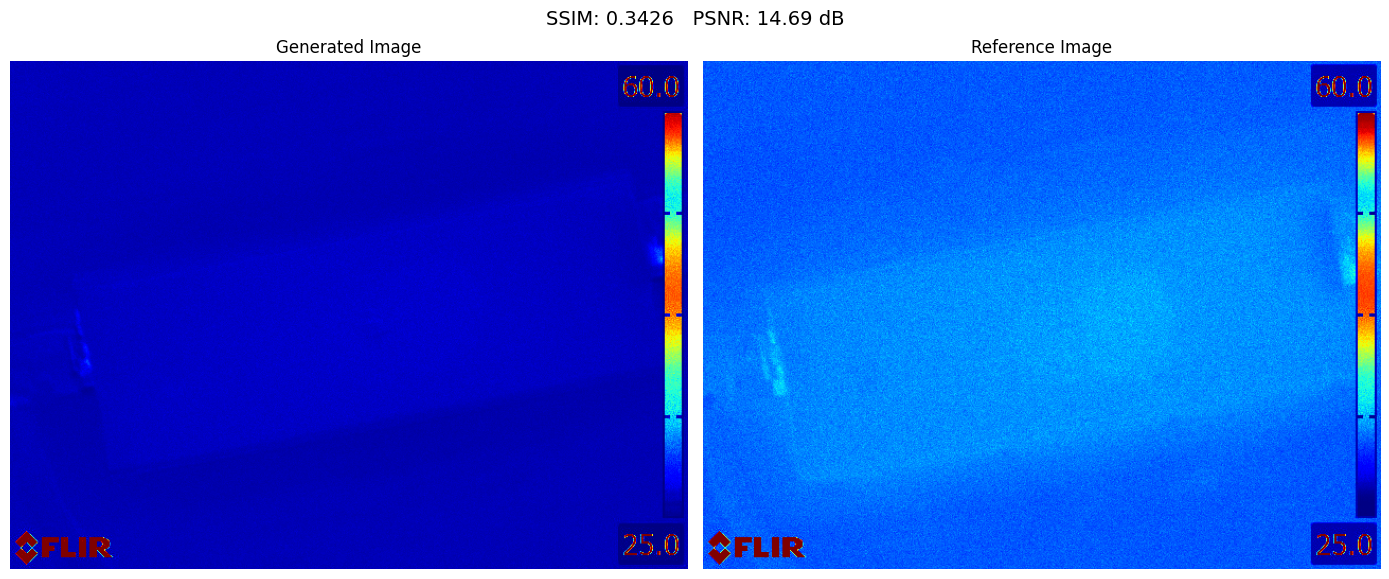